# **Loading and Cleaning the Data**

In [1]:
import pandas as pd

train_data = pd.read_csv('/kaggle/input/predict-the-wind-speed-at-a-wind-turbine/train.csv', parse_dates=['Timestamp'])
test_data = pd.read_csv('/kaggle/input/predict-the-wind-speed-at-a-wind-turbine/test.csv', parse_dates=['Timestamp'])

train_data.drop(columns=['Unnamed: 0','training'], inplace=True, errors='ignore')
test_data.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')

for col in train_data.columns:
    if col != 'Timestamp':
        train_data[col] = pd.to_numeric(train_data[col], errors='coerce')

for col in test_data.columns:
    if col != 'Timestamp':
        test_data[col] = pd.to_numeric(test_data[col], errors='coerce')

train_data.fillna(train_data.mean(), inplace=True)
test_data.fillna(test_data.mean(), inplace=True)


print(train_data.info())
print(test_data.info())


/tmp/ipykernel_23/2121757362.py:3: DtypeWarning: Columns (0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('/kaggle/input/predict-the-wind-speed-at-a-wind-turbine/train.csv', parse_dates=['Timestamp'])
/tmp/ipykernel_23/2121757362.py:4: DtypeWarning: Columns (0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv('/kaggle/input/predict-the-wind-speed-at-a-wind-turbine/test.csv', parse_dates=['Timestamp'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130610 entries, 0 to 130609
Data columns (total 52 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   Timestamp                                   130610 non-null  datetime64[ns]
 1   Wind speed (m/s)                            130610 non-null  float64       
 2   Wind speed (m/s).1                          130610 non-null  float64       
 3   Wind speed (m/s).2                          130610 non-null  float64       
 4   Wind speed (m/s).3                          130610 non-null  float64       
 5   Wind speed (m/s).4                          130610 non-null  float64       
 6   Wind speed, Standard deviation (m/s)        130610 non-null  float64       
 7   Wind speed, Standard deviation (m/s).1      130610 non-null  float64       
 8   Wind speed, Standard deviation (m/s).2      130610 non-null  float64      

# Feature Engineering

In [2]:
import numpy as np

def add_cyclic_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add cyclic time-based features to the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame with a 'Timestamp' column.

    Returns:
        pd.DataFrame: DataFrame with added cyclic features.
    """
    df['minute_sin'] = np.sin(2 * np.pi * df['Timestamp'].dt.minute / 60)
    df['minute_cos'] = np.cos(2 * np.pi * df['Timestamp'].dt.minute / 60)

    df['hour_sin'] = np.sin(2 * np.pi * df['Timestamp'].dt.hour / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Timestamp'].dt.hour / 24)

    df['day_sin'] = np.sin(2 * np.pi * df['Timestamp'].dt.dayofyear / 365)
    df['day_cos'] = np.cos(2 * np.pi * df['Timestamp'].dt.dayofyear / 365)

    df['month_sin'] = np.sin(2 * np.pi * df['Timestamp'].dt.month / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['Timestamp'].dt.month / 12)

    return df

def add_wind_direction_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add sine and cosine transformations for wind direction features.

    Args:
        df (pd.DataFrame): The DataFrame containing wind direction columns.

    Returns:
        pd.DataFrame: DataFrame with added wind direction sine and cosine features.
    """
    wind_cols = ['Wind direction (°)', 'Wind direction (°).1', 'Wind direction (°).2',
                'Wind direction (°).3', 'Wind direction (°).4']

    for col in wind_cols:
        if col in df.columns:
            df[f'{col}_sin'] = np.sin(np.radians(df[col]))
            df[f'{col}_cos'] = np.cos(np.radians(df[col]))
    
    return df

def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Complete preprocessing pipeline: datetime parsing, feature engineering.

    Args:
        df (pd.DataFrame): The DataFrame to preprocess.
        target_feature (str): The name of the target variable.

    Returns:
        pd.DataFrame: Preprocessed DataFrame.
    """
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

    df = add_cyclic_features(df)
    df = add_wind_direction_features(df)

    return df

train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

# Training the Model 

In [3]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

train_data.set_index('Timestamp', inplace=True)
test_data.set_index('Timestamp', inplace=True)

target_feature = 'target_feature' 
features = [col for col in train_data.columns if col != target_feature]

X = train_data[features]
y = train_data[target_feature]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
params = {
    'num_leaves': 90,
    'learning_rate': 0.02,
    'n_estimators': 3500,
    'min_data_in_leaf': 50,
    'max_depth': 24,  
    'feature_fraction': 0.6,  
    'bagging_fraction': 0.8,  
    'bagging_freq': 1, 
    'lambda_l1': 0.1, 
    'lambda_l2': 0,
    'random_state': 42,
    'device': 'gpu'
}

model = lgb.LGBMRegressor(**params)
model.fit(X_train_scaled, y_train)


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current 

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 64 dense feature groups (6.38 MB) transferred to GPU in 0.006380 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6.392961


LGBMRegressor(bagging_fraction=0.8, bagging_freq=1, device='gpu',
              feature_fraction=0.6, lambda_l1=0.1, lambda_l2=0,
              learning_rate=0.02, max_depth=24, min_data_in_leaf=50,
              n_estimators=3500, num_leaves=90, random_state=42)

# Evaluation and Plotting 

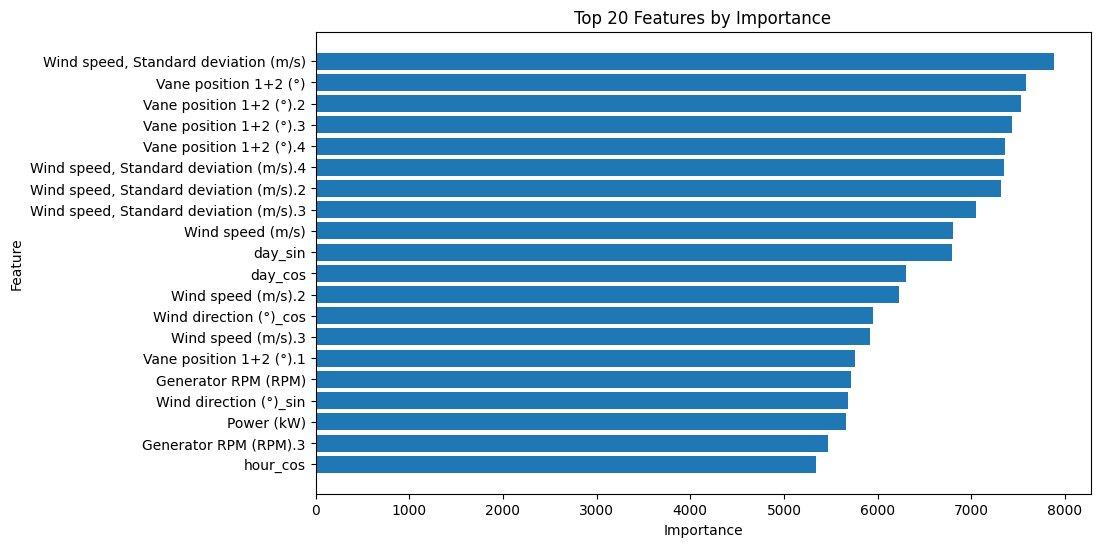

In [4]:
importances = model.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Features by Importance')
plt.gca().invert_yaxis() 
plt.show()


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
Validation MAE: 0.33481720636758566
Validation RMSE: 0.4526712209124848


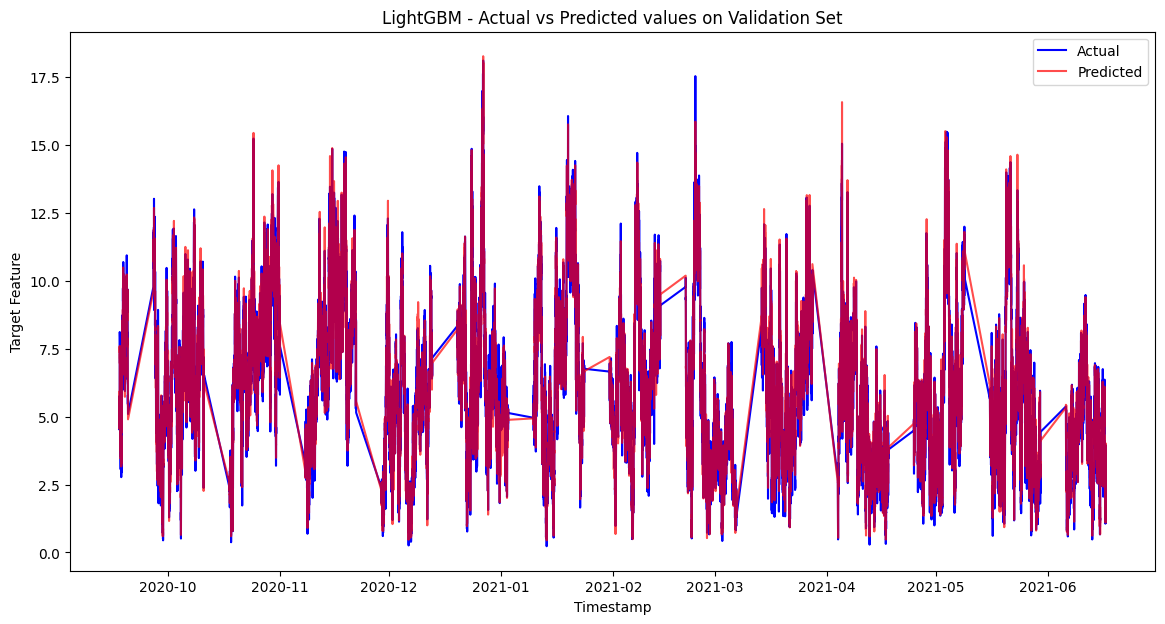

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


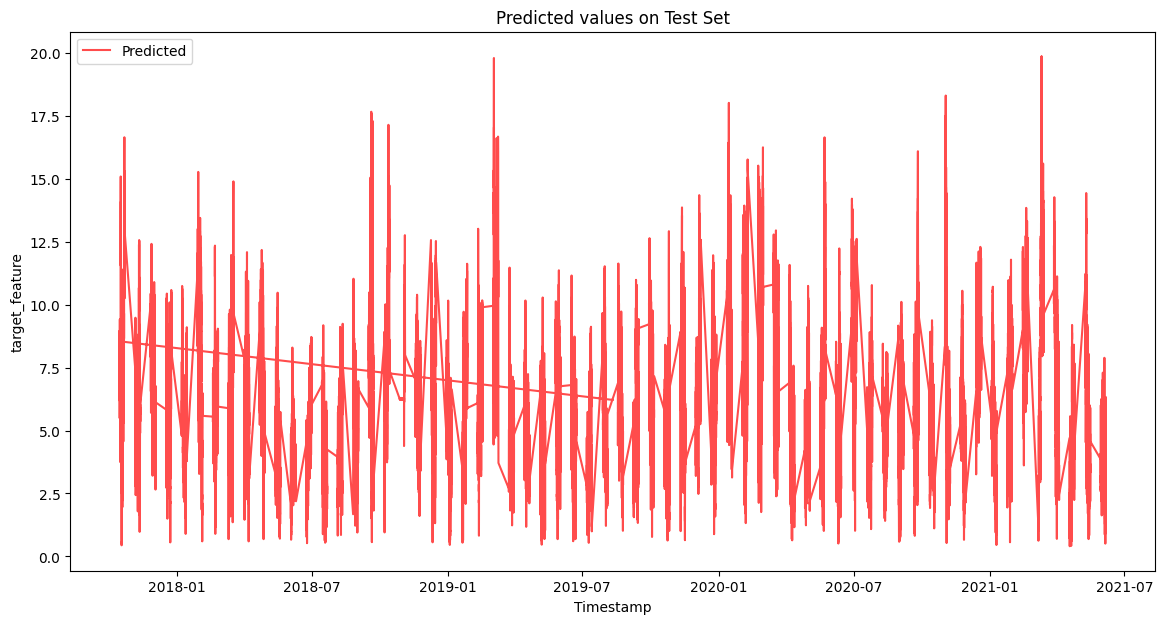

In [5]:

y_val_pred = model.predict(X_val_scaled)

mae = mean_absolute_error(y_val, y_val_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print("Validation MAE:", mae)
print("Validation RMSE:", rmse)


plt.figure(figsize=(14, 7))
plt.plot(y_val.index, y_val, label="Actual", color="blue")
plt.plot(y_val.index, y_val_pred, label="Predicted", color="red", alpha=0.7)
plt.xlabel("Timestamp")
plt.ylabel("Target Feature")
plt.title("LightGBM - Actual vs Predicted values on Validation Set")
plt.legend()
plt.show()


X_test_scaled = scaler_X.transform(test_data[features])


y_test_pred = model.predict(X_test_scaled)


plt.figure(figsize=(14, 7))
plt.plot(test_data.index, y_test_pred, label="Predicted", color="red", alpha=0.7)
plt.xlabel("Timestamp")
plt.ylabel(target_feature)
plt.title("Predicted values on Test Set")
plt.legend()
plt.show()
